# Notes from previous session

Data cleaning:
- **[DONE]** weekly aggregation
- **[DONE]** monthly aggregation
- **[DONE]** join same products with different names
- **[DONE]** automated and cleaned all code
- **[DONE]** added time related hot encodings
- **[DONE]** added gross_sales/discounts as features on their corresponding level
- **[--]** add holiday times for the model as a new feature
- **[DONE]** sku level (product and color)

Modeling:
- finish prediction for the top2/top3 products (all different colors)
- simple classification algorithm/or manual selection of different types of time series 
(1. ones with abundant and regular data 2. ones with insufficient data and unclear seasonality)
- do different models for different groups of time series 

# Read in data

In [2]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import os
import itertools
from prophet.diagnostics import performance_metrics
import joblib
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

ModuleNotFoundError: No module named 'pandas'

In [87]:
orders_file = "./sales_2019-01-01_2022-08-16.csv"
scooter_df = pd.read_csv(orders_file, keep_default_na=False) #daily order file
scooter_df['date'] = pd.to_datetime(scooter_df['day'])
scooter_df = scooter_df.sort_values('date')
scooter_df.head(1)

,product_title,variant_title,variant_sku,shipping_country,product_vendor,shipping_postal_code,day,net_quantity,gross_sales,discounts,returns,net_sales,taxes,total_sales,date
3856,EMOVE Cruiser 52V 1600W Dual Suspension Foldab...,30.5AH (62 miles) / Black,emove-305-black,Switzerland,EMOVE,1290,2019-01-06,1,1899.0,0.0,0.0,1899.0,0.0,1899.0,2019-01-06


# Data cleaning

In [88]:
# before doing any type of aggregation, we need to update all skus to the latest sku
latest_info = """'touring-156-black', > Touring-Black
'emove-305-orange', - not sure what product this is. should not use this sku, could be Cruiser/Touring
'emove-26-white', - not sure what product this is. should not use this sku, could be Cruiser/Touring
'emove-305-black', - not sure what product this is. should not use this sku, could be Cruiser/Touring
'emove-26-black', - not sure what product this is. should not use this sku, could be Cruiser/Touring
'emove-305-white', - not sure what product this is. should not use this sku, could be Cruiser/Touring
'emove-white', - not sure what product this is. should not use this sku, could be Cruiser/Touring
'touring-156-orange', > Touring-Orange
'touring-104-white', > Touring-White
'emove-26-orange', not sure what product this is. should not use this sku, could be Cruiser/Touring
'emove-26-green', not sure what product this is. should not use this sku, could be Cruiser/Touring
'touring-21-white', > Touring-White
'touring-21-orange', > Touring-Orange
'touring-156-white', > Touring-White
'touring-156-green', - Discontinued
'emove-black', not sure what product this is. should not use this sku, could be Cruiser/Touring
'touring-21-green', - Discontinued
'CRUISER-Orange',
'Touring-Black',
'CRUISER-Black',
'CRUISER-White',
'Touring-White',
'Touring-Orange',
'FIIDO-Q1s-Black',
'FIIDO-Q1s-Red', - Discontinued
'FIIDO-Q1s-Green',
'FIIDO-Q1s-White', - Discontinued
'FIIDO-Q1-Black',
'FIIDO-Q1-Green', - Discontinued
'FIIDO-Q1-Red', - Discontinued
'FIIDO-Q1-White', - Discontinued
'Wolf-Warrior-Street-Tires', - Discontinued
'Wolf-Warrior-Off-Road-Tires', - Discontinued
'KAABO-MantisPro-Gold', 
'CRUISER-Purple', 
'KAABO-wolf-king',
'Cruiser-Purple', 
'CRUISER-Red', 
'TOURING-Red',
'Cruiser-Red-New', > Cruiser-Red
'Touring-Purple', 
'KAABO-offroad-wolf-king',
'Early-2021-CRUISER-Orange', > CRUISER-Orange
'Early-2021-CRUISER-Black', > Cruiser-Black
'Early-2021-CRUISER-White', > Cruiser-White
'Touring-Red',
'Early-2021-Cruiser-Red-New', > Cruiser-Red
'KAABO-MantisPro-Gold-18.2AH',
'Cruiser-Black', 
'KAABO-MantisPro-Gold-24AH',
'Black-KAABO-wolf-king', 
'2022-KAABO-MantisPro-Gold-18.2AH',
'2022-KAABO-MantisPro-Gold-24AH', 
'Black-KAABO-offroad-wolf-king',
'WKGT-Gold-Street',
'Early-2021-Cruiser-Purple', > Cruiser-Purple
'WKGT-Gold-OffRoad', 
'dualtron-victor', 
'EMOVE-Roadrunner',
'Dualtron-X2', - Discontinuing
'dualtron-storm', - Discontinuing
'dualtron-mini', - Discontinuing
'Cruiser-Yellow', - Discontinuing
'dualtron-eagle-pro',
'Dualtron-Storm-Limited',
'Dualtron-Thunder2',
'dualtron-thunder', - Discontinuing
'Kaabo-Wolf-Warrior-GT-street', 
'dualtron-ultra-2', 
'Cruiser-Red',
'Gold-KAABO-offroad-wolf-king', 
'Black-KAABO-wolf-king-street',
'KAABO-MantisPro-Black-18.2AH', 
'WKGT-Black-OffRoad',
'WKGT-Black-Street', 
'Gold-KAABO-Wolf-King-Street',
'2022-KAABO-MantisPro-Black-18.2AH',
'dualtron-city', - Discontinuing
'Kaabo-Wolf-Warrior-GT-off-road', 
'dualtron-spider-2',
'KAABO-MantisPro-Black-24AH',
'dualtron-thunder-tronic', - Discontinued
'dualtron-victor-luxury', 
'EMOVE-Roadrunner-Tronic',
'2022-KAABO-MantisPro-Black-24AH', 
'dualtron-achilleus',
'WKGT-Gold-Racing', 
'CRUISER-Blue',
'wolf-warrior-base-black-street', - Discontinued
'wolf-warrior-x-black-street', - Discontinued
'wolf-warrior-x-gold-street', - Discontinued
'Kaabo-Mantis-King-GT', - new model, won't have past data
'Kaabo-Mantis-King-GT-Black', - new model, won't have past data
'Kaabo-Mantis-King-GT-Gold', - new model, won't have past data"""

# we create the following four variables to store the corresponding information
unchanged = []
discontinued = []
new_models = []
not_sure = []
name_change = {}
for line in latest_info.split('\n'):
  line_split = line.split(', ')
  line_split[0] = line_split[0].replace('\'', '').replace(',', '')
  if len(line_split) == 1:
    unchanged.append(line_split[0])
  elif len(line_split) == 2 and len(line_split[1]) <= 1:
    unchanged.append(line_split[0])
  elif len(line_split) == 2 and line_split[1][0] == '>':
    name_change[line_split[0]] = line_split[1].replace(' ', '').replace('>', '')
  elif len(line_split) == 2 and (line_split[1] == '- Discontinued' or line_split[1] == '- Discontinuing'):
    discontinued.append(line_split[0])
  elif line_split[1] == '- new model':
    new_models.append(line_split[0])
  else:
    not_sure.append(line_split[0])

In [89]:
skus_to_preserve = unchanged + list(name_change.keys())
print(skus_to_preserve)

['CRUISER-Orange', 'Touring-Black', 'CRUISER-Black', 'CRUISER-White', 'Touring-White', 'Touring-Orange', 'FIIDO-Q1s-Black', 'FIIDO-Q1s-Green', 'FIIDO-Q1-Black', 'KAABO-MantisPro-Gold', 'CRUISER-Purple', 'KAABO-wolf-king', 'Cruiser-Purple', 'CRUISER-Red', 'TOURING-Red', 'Touring-Purple', 'KAABO-offroad-wolf-king', 'Touring-Red', 'KAABO-MantisPro-Gold-18.2AH', 'Cruiser-Black', 'KAABO-MantisPro-Gold-24AH', 'Black-KAABO-wolf-king', '2022-KAABO-MantisPro-Gold-18.2AH', '2022-KAABO-MantisPro-Gold-24AH', 'Black-KAABO-offroad-wolf-king', 'WKGT-Gold-Street', 'WKGT-Gold-OffRoad', 'dualtron-victor', 'EMOVE-Roadrunner', 'dualtron-eagle-pro', 'Dualtron-Storm-Limited', 'Dualtron-Thunder2', 'Kaabo-Wolf-Warrior-GT-street', 'dualtron-ultra-2', 'Cruiser-Red', 'Gold-KAABO-offroad-wolf-king', 'Black-KAABO-wolf-king-street', 'KAABO-MantisPro-Black-18.2AH', 'WKGT-Black-OffRoad', 'WKGT-Black-Street', 'Gold-KAABO-Wolf-King-Street', '2022-KAABO-MantisPro-Black-18.2AH', 'Kaabo-Wolf-Warrior-GT-off-road', 'dualtro

In [91]:
# now we ony maintain the rows of skus in the unchanged list and the name_change list
row_filter_df = scooter_df.copy()
rows_to_preserve = [sku.replace(' ', '') in skus_to_preserve for sku in row_filter_df['variant_sku']]
row_filter_df = row_filter_df[rows_to_preserve]
row_filter_df

,product_title,variant_title,variant_sku,shipping_country,product_vendor,shipping_postal_code,day,net_quantity,gross_sales,discounts,returns,net_sales,taxes,total_sales,date
12022,EMOVE Cruiser 52V 1600W Dual Suspension Foldab...,Black,CRUISER-Black,United States,EMOVE,34119,2019-07-30,1,1399.0,-97.93,0.0,1301.07,0.00,1301.07,2019-07-30
12652,EMOVE Cruiser 52V 1600W Dual Suspension Foldab...,White,CRUISER-White,United States,EMOVE,97267,2019-07-31,1,1399.0,-97.93,0.0,1301.07,0.00,1301.07,2019-07-31
11912,EMOVE Cruiser 52V 1600W Dual Suspension Foldab...,Black,CRUISER-Black,United States,EMOVE,30306,2019-08-03,1,1399.0,-97.93,0.0,1301.07,0.00,1301.07,2019-08-03
11729,EMOVE Cruiser 52V 1600W Dual Suspension Foldab...,Black,CRUISER-Black,United States,EMOVE,10465,2019-08-04,1,1399.0,-50.00,0.0,1349.00,0.00,1349.00,2019-08-04
8972,EMOVE Cruiser 52V 1600W Dual Suspension Foldab...,White,CRUISER-White,United States,EMOVE,79930,2019-08-05,1,1399.0,0.00,0.0,1399.00,0.00,1399.00,2019-08-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14020,EMOVE Touring Portable and Foldable Electric S...,Stealth Black,Touring-Black,United States,EMOVE,94606,2022-08-16,1,899.0,-50.00,0.0,849.00,61.55,910.55,2022-08-16
16519,Kaabo Mantis Pro SE Electric Scooter,24 AH (2022) / Gold,2022-KAABO-MantisPro-Gold-24AH,United States,Kaabo,87124,2022-08-16,0,1995.0,0.00,-1995.0,0.00,0.00,0.00,2022-08-16
14045,EMOVE Touring Portable and Foldable Electric S...,Stealth Black,Touring-Black,United States,EMOVE,94301,2022-08-16,1,899.0,-50.00,0.0,849.00,61.55,910.55,2022-08-16
860,Wolf King GT Pro Electric Scooter,Street Tires / Gold,WKGT-Gold-Street,United States,Kaabo,77320,2022-08-16,1,3595.0,-100.00,0.0,3495.00,288.34,3783.34,2022-08-16


In [94]:
# compute a clean version of df that computes quantities per sku
df = row_filter_df[['variant_sku', 'date', 'gross_sales', 'discounts', 'net_quantity']].groupby(['variant_sku', 'date']).sum().reset_index()
df.head()

,variant_sku,date,gross_sales,discounts,net_quantity
0,2022-KAABO-MantisPro-Black-18.2AH,2022-02-03,1899.0,0.0,1
1,2022-KAABO-MantisPro-Black-18.2AH,2022-04-16,1899.0,0.0,1
2,2022-KAABO-MantisPro-Black-18.2AH,2022-04-22,1899.0,-600.0,1
3,2022-KAABO-MantisPro-Black-18.2AH,2022-05-04,5697.0,-1200.0,2
4,2022-KAABO-MantisPro-Black-18.2AH,2022-05-08,1695.0,0.0,1


In [95]:
# Changing the order of the following rows may disrupt the flow of this section
# gets rid of NaNs and empty strings

# this is not currently neccessary as we've conducted more detailed data cleaning in previous sections
df.replace(r'^s*$', float('NaN'), regex = True, inplace=True)
df.dropna(subset = ["variant_sku"], inplace=True)
df = df.reset_index()
df = df.drop('index', axis=1)
df.head()

,variant_sku,date,gross_sales,discounts,net_quantity
0,2022-KAABO-MantisPro-Black-18.2AH,2022-02-03,1899.0,0.0,1
1,2022-KAABO-MantisPro-Black-18.2AH,2022-04-16,1899.0,0.0,1
2,2022-KAABO-MantisPro-Black-18.2AH,2022-04-22,1899.0,-600.0,1
3,2022-KAABO-MantisPro-Black-18.2AH,2022-05-04,5697.0,-1200.0,2
4,2022-KAABO-MantisPro-Black-18.2AH,2022-05-08,1695.0,0.0,1


# Different granularity of data + encodings for week/month/year

In [110]:
# Prep for different granularity of data
df['week'] = df['date'].dt.week
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,variant_sku,date,gross_sales,discounts,net_quantity,week,year,month
0,2022-KAABO-MantisPro-Black-18.2AH,2022-02-03,1899.0,0.0,1,5,2022,2
1,2022-KAABO-MantisPro-Black-18.2AH,2022-04-16,1899.0,0.0,1,15,2022,4
2,2022-KAABO-MantisPro-Black-18.2AH,2022-04-22,1899.0,-600.0,1,16,2022,4
3,2022-KAABO-MantisPro-Black-18.2AH,2022-05-04,5697.0,-1200.0,2,18,2022,5
4,2022-KAABO-MantisPro-Black-18.2AH,2022-05-08,1695.0,0.0,1,18,2022,5


In [111]:
# The following code 
df_daily = df[['variant_sku', 'date', 'week', 'month', 'year', 'gross_sales', 'discounts', 'net_quantity']]

df_weekly = df.groupby(['variant_sku', 'week', 'year']).agg({'date': 'min', 'net_quantity': 'sum', 'gross_sales':	'sum', 'discounts':	'sum', 'month': 'min'}).reset_index().sort_values(['variant_sku', 'date']).reset_index()
df_weekly = df_weekly[['variant_sku', 'date', 'week', 'month', 'year', 'gross_sales', 'discounts', 'net_quantity']]

df_monthly = df.groupby(['variant_sku', 'month', 'year']).agg({'date': 'min', 'net_quantity': 'sum', 'gross_sales':	'sum', 'discounts':	'sum', 'week': 'min'}).reset_index().sort_values(['variant_sku', 'date']).reset_index()
df_monthly = df_monthly[['variant_sku', 'date', 'week', 'month', 'year', 'gross_sales', 'discounts', 'net_quantity']]

In [112]:
df_daily.head()

,variant_sku,date,week,month,year,gross_sales,discounts,net_quantity
0,2022-KAABO-MantisPro-Black-18.2AH,2022-02-03,5,2,2022,1899.0,0.0,1
1,2022-KAABO-MantisPro-Black-18.2AH,2022-04-16,15,4,2022,1899.0,0.0,1
2,2022-KAABO-MantisPro-Black-18.2AH,2022-04-22,16,4,2022,1899.0,-600.0,1
3,2022-KAABO-MantisPro-Black-18.2AH,2022-05-04,18,5,2022,5697.0,-1200.0,2
4,2022-KAABO-MantisPro-Black-18.2AH,2022-05-08,18,5,2022,1695.0,0.0,1


In [113]:
df_weekly.head()

,variant_sku,date,week,month,year,gross_sales,discounts,net_quantity
0,2022-KAABO-MantisPro-Black-18.2AH,2022-02-03,5,2,2022,1899.0,0.0,1
1,2022-KAABO-MantisPro-Black-18.2AH,2022-04-16,15,4,2022,1899.0,0.0,1
2,2022-KAABO-MantisPro-Black-18.2AH,2022-04-22,16,4,2022,1899.0,-600.0,1
3,2022-KAABO-MantisPro-Black-18.2AH,2022-05-04,18,5,2022,7392.0,-1200.0,3
4,2022-KAABO-MantisPro-Black-18.2AH,2022-05-11,19,5,2022,6780.0,-150.0,4


In [114]:
df_monthly.head()

,variant_sku,date,week,month,year,gross_sales,discounts,net_quantity
0,2022-KAABO-MantisPro-Black-18.2AH,2022-02-03,5,2,2022,1899.0,0.0,1
1,2022-KAABO-MantisPro-Black-18.2AH,2022-04-16,15,4,2022,3798.0,-600.0,2
2,2022-KAABO-MantisPro-Black-18.2AH,2022-05-04,18,5,2022,15867.0,-3045.0,8
3,2022-KAABO-MantisPro-Black-18.2AH,2022-08-16,33,8,2022,1695.0,-50.0,0
4,2022-KAABO-MantisPro-Black-24AH,2022-04-20,16,4,2022,2299.0,-50.0,1


# Automation for data extraction per sku

In [115]:
# the top sold skus
df[['variant_sku', 'net_quantity']].groupby(['variant_sku']).sum().reset_index().sort_values('net_quantity', ascending=False)

,variant_sku,net_quantity
9,CRUISER-Orange,2290
7,CRUISER-Black,1776
13,Cruiser-Black,1772
12,CRUISER-White,1424
14,Cruiser-Purple,720
41,Touring-Black,693
33,KAABO-MantisPro-Gold,535
42,Touring-Orange,472
50,WKGT-Gold-Street,444
19,EMOVE-Roadrunner,381


In [118]:
def ith_best_seller(i):
  sum_of_sales_units = df[['variant_sku', 'net_quantity']].groupby(['variant_sku']).sum().reset_index()
  return sum_of_sales_units.sort_values('net_quantity', ascending=False).iloc[i]['variant_sku']

ith = 0
print('The {}th best seller is'.format(ith), ith_best_seller(ith))

The 0th best seller is CRUISER-Orange


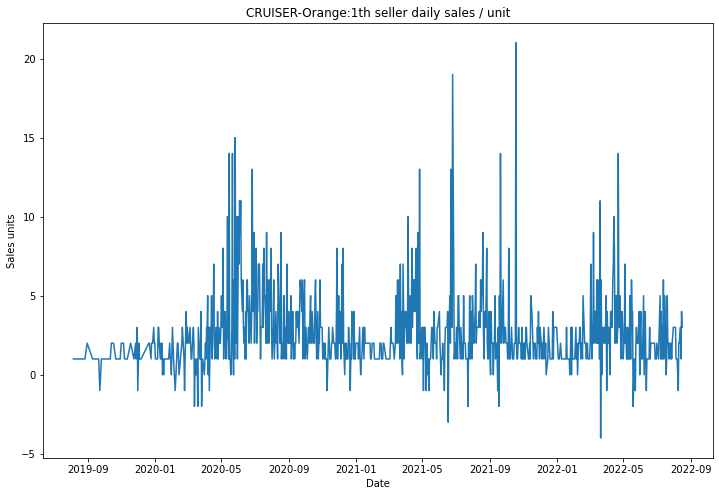

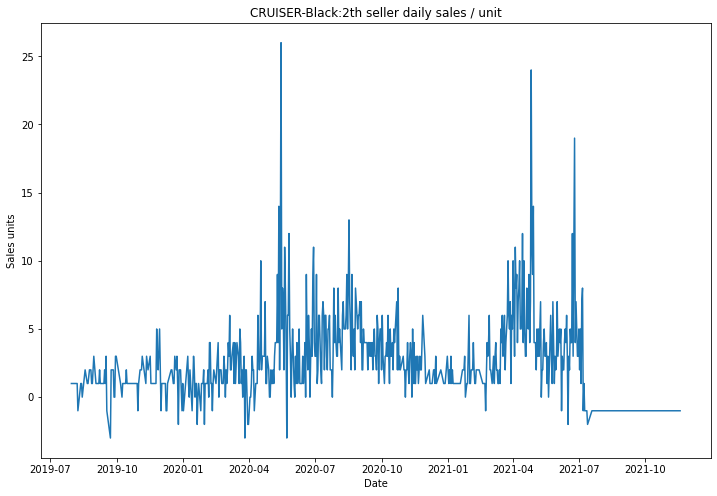

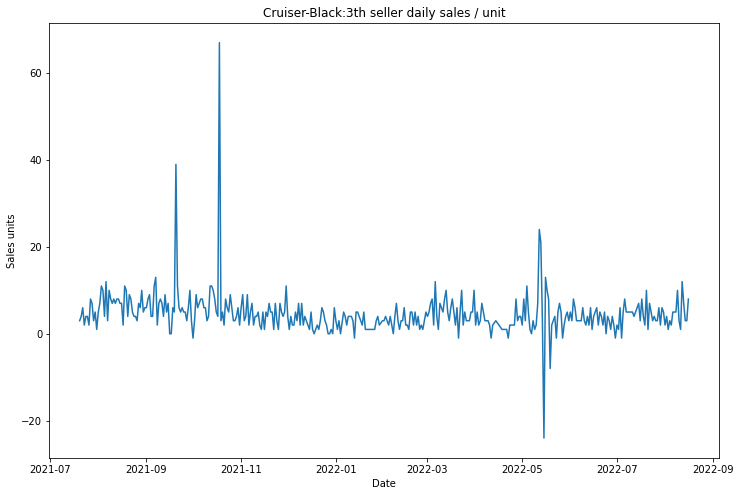

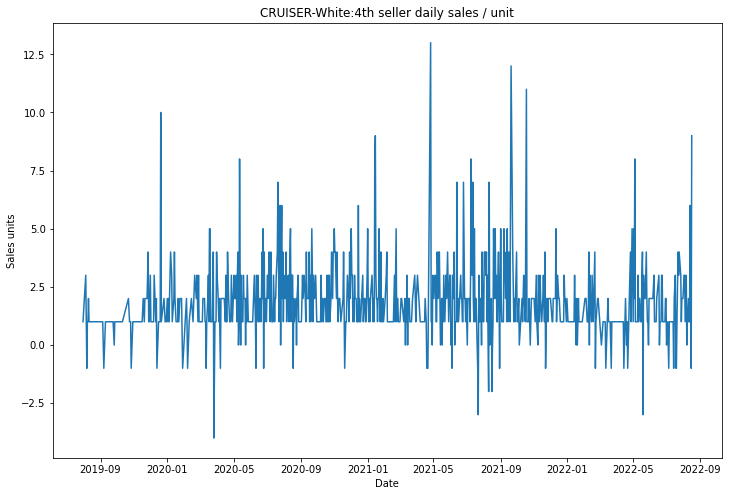

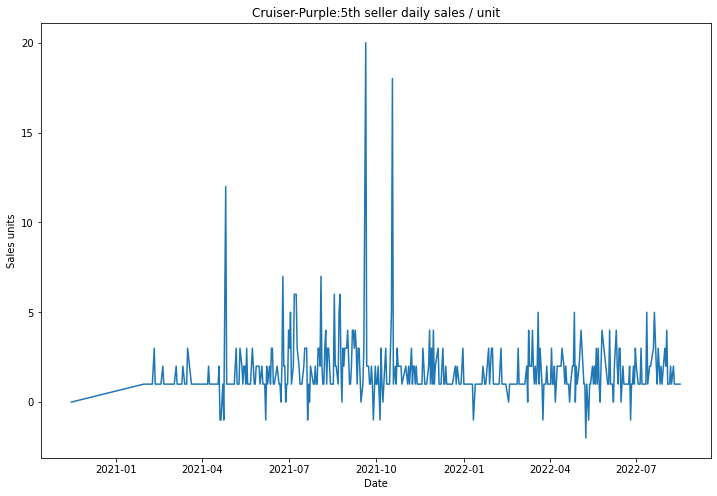

In [120]:
# plot top 5 daily
for rank in range(5):
  rank_seller = ith_best_seller(rank)
  # Plot scatter
  fig = plt.figure(figsize=(12, 8))
  plt.plot(df[df['variant_sku'] == rank_seller]['date'], df[df['variant_sku'] == rank_seller]["net_quantity"])

  # Labelling 

  plt.xlabel("Date")
  plt.ylabel("Sales units")
  plt.title(rank_seller + ':' + str(rank+1) + 'th seller daily sales / unit')

  # Display
  plt.show()


In [1]:
# plot top 5 weekly
for rank in range(5):
  rank_seller = ith_best_seller(rank)
  # Plot scatter
  fig = plt.figure(figsize=(12, 8))
  plt.plot(df_weekly[df_weekly['variant_sku'] == rank_seller]['date'], df_weekly[df_weekly['variant_sku'] == rank_seller]["net_quantity"], linestyle="--", marker="o")

  # Labelling 

  plt.xlabel("Date")
  plt.ylabel("Sales units")
  plt.title(rank_seller + ':' + str(rank+1) + 'th seller daily sales / unit')

  # Display
  plt.show()


NameError: name 'ith_best_seller' is not defined

In [158]:
# we want to take at the spike days
for rank in range(5):
  rank_seller = ith_best_seller(rank)
  sku_data = df_weekly[df_weekly['variant_sku'] == rank_seller].reset_index()[['variant_sku', 'date', 'week', 'month', 'year', 'gross_sales', 'discounts', 'net_quantity']]
  print(sku_data[sku_data['net_quantity'] > 10])

        variant_sku       date  week  month  year  gross_sales  discounts  \
20   CRUISER-Orange 2020-01-06     2      1  2020      18187.0   -3591.12   
28   CRUISER-Orange 2020-03-02    10      3  2020      15389.0   -3166.93   
33   CRUISER-Orange 2020-04-06    15      4  2020      20985.0   -1359.07   
34   CRUISER-Orange 2020-04-13    16      4  2020      39172.0  -12137.02   
35   CRUISER-Orange 2020-04-21    17      4  2020      20985.0   -1303.80   
..              ...        ...   ...    ...   ...          ...        ...   
146  CRUISER-Orange 2022-05-30    22      5  2022      20985.0   -1599.00   
147  CRUISER-Orange 2022-06-07    23      6  2022      19387.0    -273.47   
151  CRUISER-Orange 2022-07-04    27      7  2022      20986.0   -1926.02   
152  CRUISER-Orange 2022-07-11    28      7  2022      32978.0   -3806.15   
153  CRUISER-Orange 2022-07-18    29      7  2022      22485.0   -3069.86   

     net_quantity  
20             12  
28             11  
33             

# Auto data extractor

In [126]:
# the following code extracts data on a daily basis 
def extract_data(rank, granularity = 'daily'):
  sku = ith_best_seller(rank)
  print('Currently extracting data for product {} with rank {} (indexed starting from 0) on a {} granularity......'.format(sku, rank, granularity))
  if granularity == 'daily':
    return df_daily[df_daily['variant_sku'] == sku].sort_values('date').reset_index()[['variant_sku', 'date', 'week', 'month', 'year', 'gross_sales', 'discounts', 'net_quantity']]
  elif granularity == 'weekly':
    return df_weekly[df_weekly['variant_sku'] == sku].sort_values('date').reset_index()[['variant_sku', 'date', 'week', 'month', 'year', 'gross_sales', 'discounts', 'net_quantity']]
  elif granularity == 'monthly':
    return df_monthly[df_monthly['variant_sku'] == sku].sort_values('date').reset_index()[['variant_sku', 'date', 'week', 'month', 'year', 'gross_sales', 'discounts', 'net_quantity']]
  else:
    print("Desired granularity is invalid")

extract_data(0, 'weekly')

Currently extracting data for product CRUISER-Orange with rank 0 (indexed starting from 0) on a weekly granularity......


,variant_sku,date,week,month,year,gross_sales,discounts,net_quantity
0,CRUISER-Orange,2019-08-06,32,8,2019,1399.00,-97.93,1
1,CRUISER-Orange,2019-08-12,33,8,2019,5596.00,-50.00,3
2,CRUISER-Orange,2019-08-27,35,8,2019,4197.00,0.00,3
3,CRUISER-Orange,2019-09-10,37,9,2019,4197.00,-97.93,3
4,CRUISER-Orange,2019-09-20,38,9,2019,2798.00,0.00,2
...,...,...,...,...,...,...,...,...
153,CRUISER-Orange,2022-07-18,29,7,2022,22485.00,-3069.86,13
154,CRUISER-Orange,2022-07-26,30,7,2022,13491.00,-1699.00,9
155,CRUISER-Orange,2022-08-02,31,8,2022,13513.81,-3770.81,9
156,CRUISER-Orange,2022-08-09,32,8,2022,13513.89,-2066.61,7


# Splitting test and train data

In [128]:
# Split data in train and test
df_final = extract_data(0)

train_percentage = 0.8
train_final_index = round(len(df_final) * (train_percentage))
train = df_final[0:train_final_index]
test = df_final[train_final_index:]

train.head()

Currently extracting data for product CRUISER-Orange with rank 0 (indexed starting from 0) on a daily granularity......


,variant_sku,date,week,month,year,gross_sales,discounts,net_quantity
0,CRUISER-Orange,2019-08-06,32,8,2019,1399.0,-97.93,1
1,CRUISER-Orange,2019-08-12,33,8,2019,2798.0,0.00,1
2,CRUISER-Orange,2019-08-17,33,8,2019,1399.0,-50.00,1
3,CRUISER-Orange,2019-08-18,33,8,2019,1399.0,0.00,1
4,CRUISER-Orange,2019-08-27,35,8,2019,1399.0,0.00,1


In [129]:
# y_test = cruiser_df[['y']][train_final_index:]
train.columns = ['variant_sku', 'ds', 'week', 'month', 'year', 'gross_sales', 'discounts', 'y']
test.columns = ['variant_sku', 'ds', 'week', 'month', 'year', 'gross_sales', 'discounts', 'y']

In [161]:
train.head()

,variant_sku,ds,week,month,year,gross_sales,discounts,y
0,CRUISER-Orange,2019-08-06,32,8,2019,1399.0,-97.93,1
1,CRUISER-Orange,2019-08-12,33,8,2019,2798.0,0.00,1
2,CRUISER-Orange,2019-08-17,33,8,2019,1399.0,-50.00,1
3,CRUISER-Orange,2019-08-18,33,8,2019,1399.0,0.00,1
4,CRUISER-Orange,2019-08-27,35,8,2019,1399.0,0.00,1


In [162]:
test.head()

,variant_sku,ds,week,month,year,gross_sales,discounts,y
702,CRUISER-Orange,2022-01-29,4,1,2022,1399.0,-97.93,1
703,CRUISER-Orange,2022-01-30,4,1,2022,1399.0,0.00,1
704,CRUISER-Orange,2022-02-02,5,2,2022,1399.0,-50.00,1
705,CRUISER-Orange,2022-02-03,5,2,2022,2798.0,-1496.93,2
706,CRUISER-Orange,2022-02-04,5,2,2022,4197.0,-195.86,3


DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7_oxd11/4xx1swhj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7_oxd11/r8kh8i3w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73928', 'data', 'file=/tmp/tmpf7_oxd11/4xx1swhj.json', 'init=/tmp/tmpf7_oxd11/r8kh8i3w.json', 'output', 'file=/tmp/tmpr9d81asp/prophet_model-20220823165331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:53:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:53:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Squared Error: 2.4403557920577255


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
171,2022-08-11,2.647020,-4.320592,11.990320,-4.792250,9.108161,1.512869,1.512869,1.512869,1.512869,1.512869,1.512869,0.0,0.0,0.0,4.159889
172,2022-08-13,2.649835,-3.836773,11.973394,-4.900692,9.281449,1.530502,1.530502,1.530502,1.530502,1.530502,1.530502,0.0,0.0,0.0,4.180337
173,2022-08-14,2.651242,-4.795747,12.122146,-4.924017,9.368094,1.513329,1.513329,1.513329,1.513329,1.513329,1.513329,0.0,0.0,0.0,4.164572
174,2022-08-15,2.652650,-4.830343,11.837086,-4.946820,9.454738,1.479522,1.479522,1.479522,1.479522,1.479522,1.479522,0.0,0.0,0.0,4.132171
175,2022-08-16,2.654057,-4.884445,12.295300,-4.969615,9.541382,1.430098,1.430098,1.430098,1.430098,1.430098,1.430098,0.0,0.0,0.0,4.084155


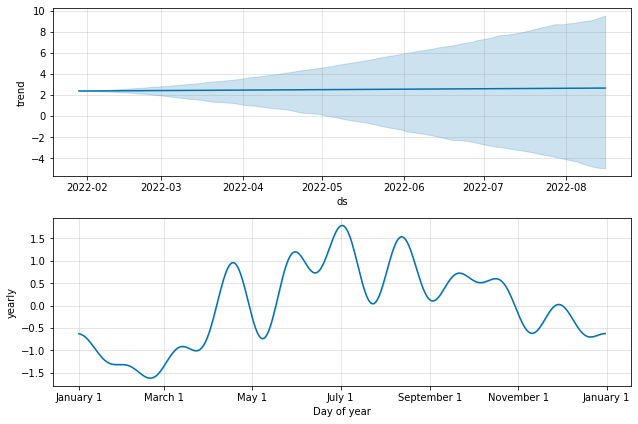

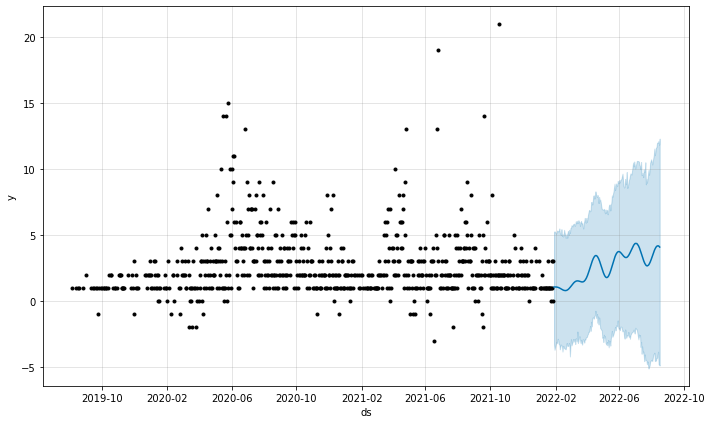

In [140]:
model = Prophet(changepoint_prior_scale= 1, 
                seasonality_prior_scale=5., 
                holidays_prior_scale= 0.01, 
        yearly_seasonality = True, 
        weekly_seasonality = False,
        daily_seasonality = False, 
        interval_width=0.95)


# model.fit(cruiser_df_train)
# prediction = model.predict(cruiser_df_test)

model.fit(train)
forecast = model.predict(test)
model.plot_components(forecast)

print('Root Mean Squared Error:', np.sqrt(mean_squared_error(test['y'], forecast['yhat'])))
#print('R2 score - ', r2_score(test[-7:], prediction['yhat'][-7:]))
model.plot(forecast)

forecast.tail()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7_oxd11/j7_vgsbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf7_oxd11/xwb3098_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69628', 'data', 'file=/tmp/tmpf7_oxd11/j7_vgsbi.json', 'init=/tmp/tmpf7_oxd11/xwb3098_.json', 'output', 'file=/tmp/tmptq71qgxu/prophet_model-20220823194924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:49:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Squared Error: 0.8465787032653421
Mean Absolute Percentage Error: 4.77954825784357


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
171,2022-08-11,1.243842,0.215263,3.676552,-0.151177,2.663250,0.635367,0.635367,0.635367,1.361581,...,-0.065553,-0.065553,-0.065553,0.007191,0.007191,0.007191,0.0,0.0,0.0,1.879209
172,2022-08-13,1.243952,1.397303,4.705128,-0.167575,2.689287,1.804191,1.804191,1.804191,1.361581,...,0.062014,0.062014,0.062014,-0.008528,-0.008528,-0.008528,0.0,0.0,0.0,3.048143
173,2022-08-14,1.244007,-0.652674,2.656911,-0.176228,2.702307,-0.262319,-0.262319,-0.262319,1.361581,...,0.117253,0.117253,0.117253,-0.017823,-0.017823,-0.017823,0.0,0.0,0.0,0.981689
174,2022-08-15,1.244063,2.031319,5.632984,-0.184573,2.709700,2.645955,2.645955,2.645955,1.361581,...,-0.133620,-0.133620,-0.133620,-0.027822,-0.027822,-0.027822,0.0,0.0,0.0,3.890017
175,2022-08-16,1.244118,1.303428,4.728152,-0.192915,2.720981,1.756656,1.756656,1.756656,1.361581,...,0.062788,0.062788,0.062788,-0.038323,-0.038323,-0.038323,0.0,0.0,0.0,3.000774


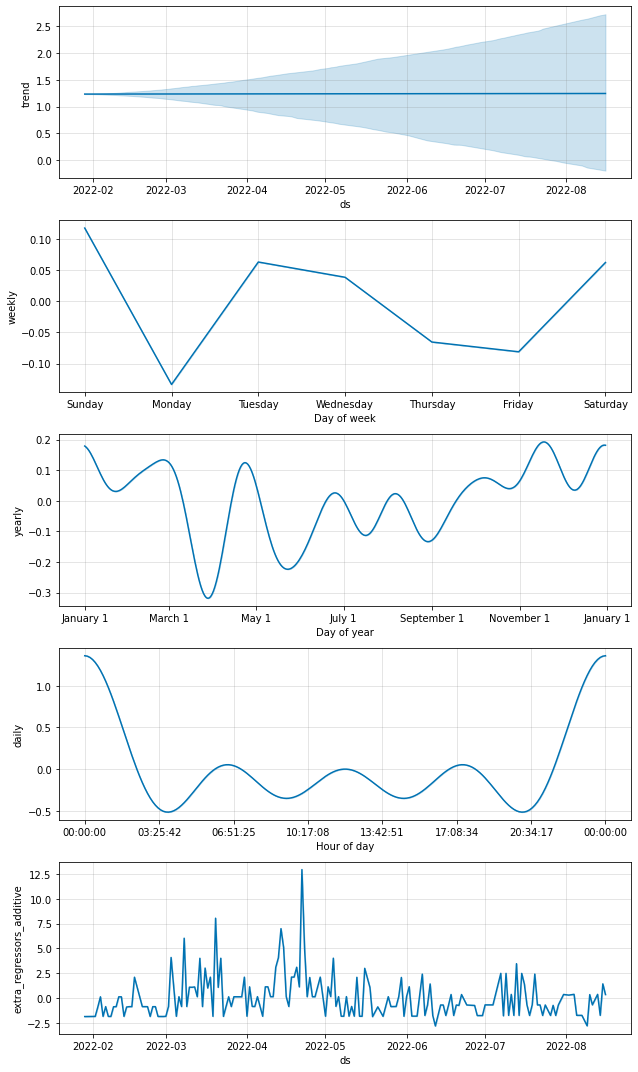

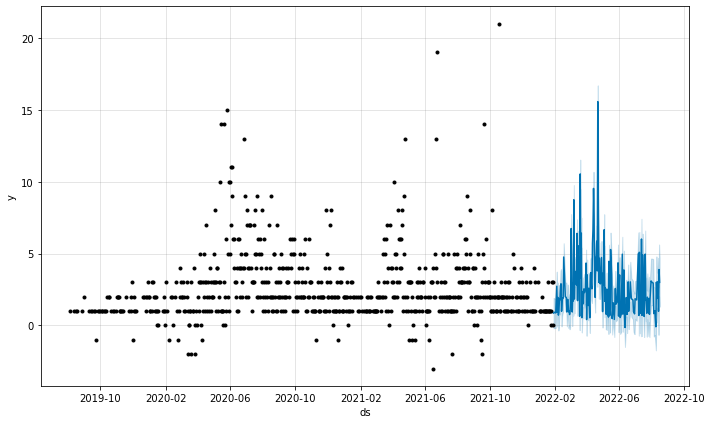

In [160]:
model = Prophet(changepoint_prior_scale= 1, 
                seasonality_prior_scale=3, 
                holidays_prior_scale= 0.01, 
        yearly_seasonality = True, 
        weekly_seasonality = True,
        daily_seasonality = True, 
        interval_width=0.95)

model.add_regressor('week')
model.add_regressor('month')
model.add_regressor('discounts')
model.add_regressor('gross_sales')

model.fit(train)
forecast = model.predict(test)
model.plot_components(forecast)

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def MAPE(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

print('Root Mean Squared Error:', np.sqrt(mean_squared_error(test['y'], forecast['yhat'])))
print('Mean Absolute Percentage Error:', np.sqrt(MAPE(test['y'], forecast['yhat'])))
#print('R2 score - ', r2_score(test[-7:], prediction['yhat'][-7:]))
model.plot(forecast)

forecast.tail()

In [ ]:
# seasonality regressor
# https://nbviewer.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb

In [ ]:
# #save as CSV file

# import os  
# os.makedirs('./Order_data/Cruiser/', exist_ok=True) 


# timeseries_df.to_csv('./Order_data/Cruiser/timeseries_df.csv', index=False) 
# more_series_df.to_csv('./Order_data/Cruiser/more_series_df.csv', index=False) 
# meta_df.to_csv('./Order_data/Cruiser/meta_df.csv', index=False) 
